# Pre-processing workflow for satellite observations of basal melt rate

This notebook removes the linear trend, seasonal signal and extracts the draft dependence parameters for basal melt from the satellite record published in _Paolo 2023_.

The draft dependence parameters are saved in a netcdf file for future use - and form the basis of the mean signal in the MALI simulations to follow for the ensemble experiments.

Note that the detrend and deseasonalize functions now ensure the mean value of the raw dataset is added back in, so that draft parameterization incorporates the mean melt rate.

In [1]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'
import gc
import collections
from pathlib import Path

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
from statsmodels.tsa.seasonal import seasonal_decompose

import numpy as np
import xarray as xr
from xeofs.xarray import EOF
import rioxarray

import dask
import distributed

import scipy
from scipy import signal
import cftime
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [3]:
# FIXIT: Jupyter Lab scheduler view for Dask not working
client = distributed.Client()
client

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51526 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:51526/status,
Dashboard: http://127.0.0.1:51526/status,Workers: 5
Total threads: 10,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51527,Workers: 5
Dashboard: http://127.0.0.1:51526/status,Total threads: 10
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:51546,Total threads: 2
Dashboard: http://127.0.0.1:51553/status,Memory: 3.20 GiB
Nanny: tcp://127.0.0.1:51530,


# Read Datasets

In [4]:
# File path directories

# inDirName = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Get full path of the aislens_emulation directory. All file IO is relative to this path.
main_dir = Path.cwd().parent
#dir_ext_data = 'data/external/'
#dir_interim_data = 'data/interim/'
DIR_external = 'data/external/'
DIR_processed = 'data/processed/'
FILE_MeltDraftObs = 'ANT_G1920V01_IceShelfMeltDraft.nc'
FILE_basalMeltObs_deSeasonalized = 'obs23_melt_anm.nc'
FILE_iceShelvesShape = 'iceShelves.geojson'

In [5]:
ICESHELVES_MASK = gpd.read_file(main_dir / DIR_external / FILE_iceShelvesShape)
icems = ICESHELVES_MASK.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [6]:
MELTDRAFT_OBS = xr.open_dataset(main_dir / DIR_external / FILE_MeltDraftObs, chunks={"x":729, "y":729})
# MELTDRAFT_OBS = xr.open_dataset(main_dir / DIR_external / FILE_MeltDraftObs)

MELTDRAFT_OBS.rio.write_crs("epsg:3031",inplace=True);

obs23_melt = MELTDRAFT_OBS.melt
obs23_draft = MELTDRAFT_OBS.draft

# Time series of spatial mean melt
obs23_melt_ts = obs23_melt.mean(dim=['x', 'y']).compute()

# Time mean of melt rate and draft
obs23_melt_tm = obs23_melt.mean(dim='time').compute()
obs23_draft_tm = obs23_draft.mean(dim='time').compute()

# Helper Functions

In [26]:
# Helper functions

def detrend_dim(data, dim, deg):
    # Store the original mean
    original_mean = data.mean(dim=dim)

    # detrend along a single dimension
    p = data.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(data[dim], p.polyfit_coefficients)
    detrended = data - fit

    # Add back the original mean
    detrended += original_mean

    return detrended

def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs)
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    #clipped_data = clipped_data.drop("month")
    return clipped_data

def find_ice_shelf_index(ice_shelf_name):
    return icems[icems['name']==ice_shelf_name].index[0]

def deseasonalize(data):
    # Group data by month
    data_month = data.groupby("time.month")

    # Calculate climatological mean for each month
    data_clm = data_month.mean("time")
    
    # Calculate deseasonalized anomalies
    data_anm = data_month - data_clm
    
    # Add back the original mean
    original_mean = data.mean("time")
    data_anm += original_mean
    
    return data_anm


def dedraft(data, draft):
    data_tm = data.mean(dim='time')
    draft_tm = draft.mean(dim='time')
    data_stack = data_tm.stack(z=('x', 'y'))
    draft_stack = draft_tm.stack(z=('x', 'y'))
    data_stack_noNaN = data_stack.fillna(0)
    draft_stack_noNaN = draft_stack.fillna(0)
    data_stack_noNaN_vals = data_stack_noNaN.values.reshape(-1,1)
    draft_stack_noNaN_vals = draft_stack_noNaN.values.reshape(-1,1)
    reg = LinearRegression().fit(draft_stack_noNaN_vals, data_stack_noNaN_vals)
    data_pred_stack_noNaN_vals = reg.predict(draft_stack_noNaN_vals).reshape(-1)
    data_pred_stack_noNaN = data_stack_noNaN.copy(data=data_pred_stack_noNaN_vals)
    data_pred_stack = data_pred_stack_noNaN.where(~data_stack.isnull(), np.nan)
    data_pred = data_pred_stack.unstack('z').transpose()
    data_dedraft = data - data_pred
    return reg.coef_, reg.intercept_, data_pred, data_dedraft

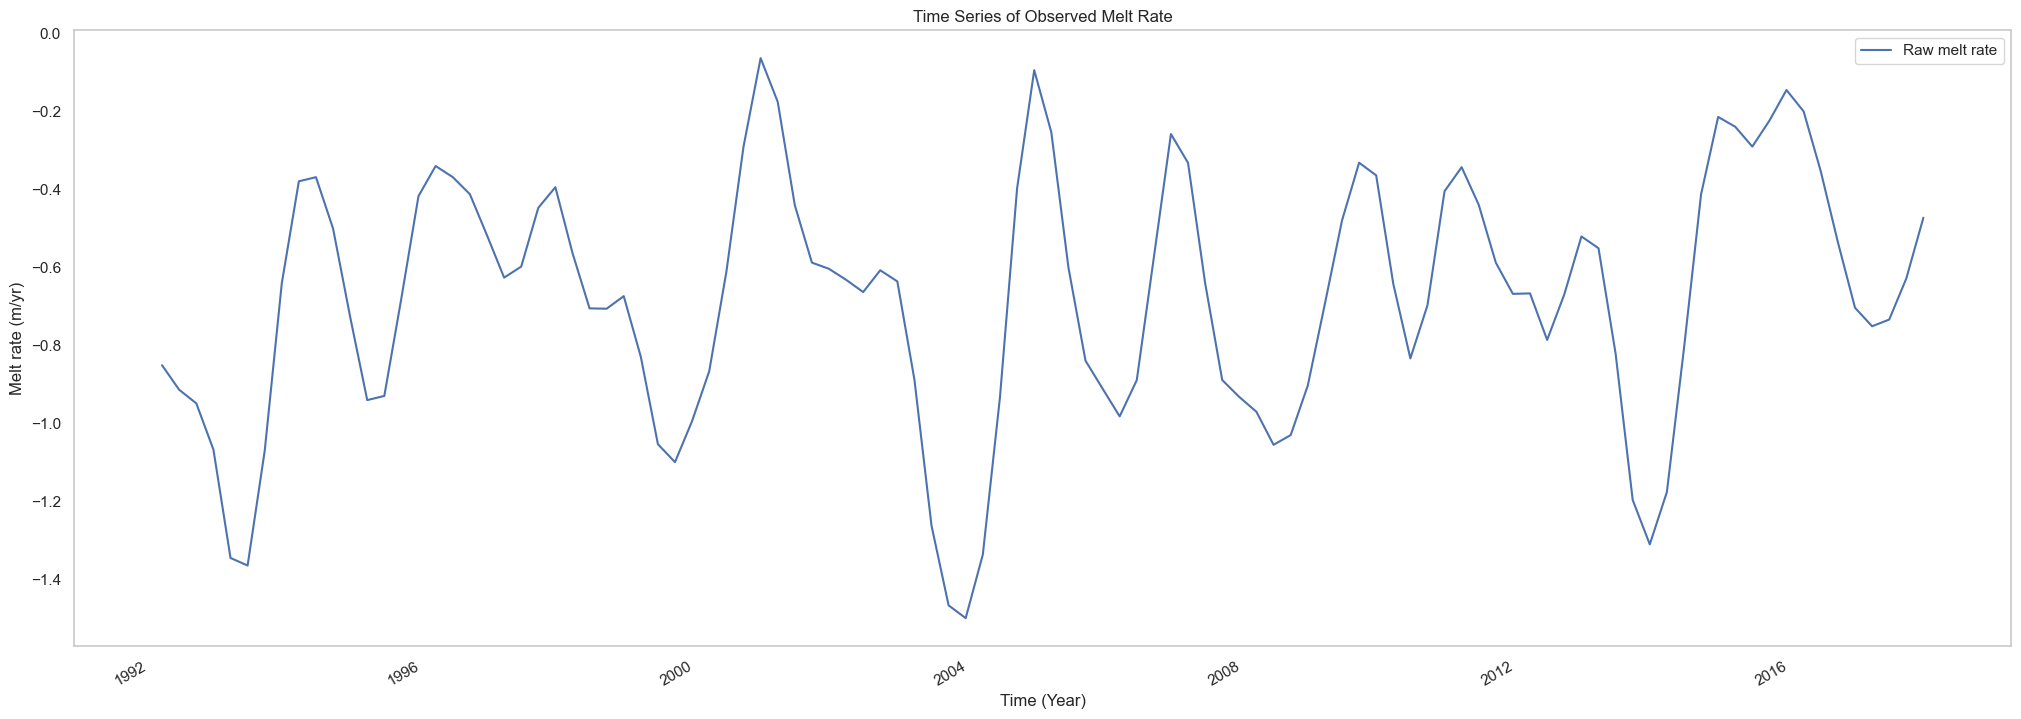

In [54]:
# Plot the time series of the melt rate variability
plt.figure(figsize=(25,8))

# Plot the raw melt rate time series
obs23_melt_ts.plot(label='Raw melt rate')

# Add labels and title
plt.xlabel('Time (Year)')
plt.ylabel('Melt rate (m/yr)')
plt.title('Time Series of Observed Melt Rate')
plt.legend()
plt.grid()
plt.show()

# Detrend: Remove linear trend signal

In [8]:
# Detrend (uniform)

obs23_melt_detrend_ts = detrend_dim(obs23_melt_ts, 'time', 1).compute()
trendfit = obs23_melt_ts - obs23_melt_detrend_ts

# Subtract the above trendfit from the melt dataset to get the detrended melt dataset
obs23_melt_detrend_uniform = obs23_melt - trendfit
obs23_melt_detrend_uniform_ts = obs23_melt_detrend_uniform.mean(dim=['x', 'y']).compute()


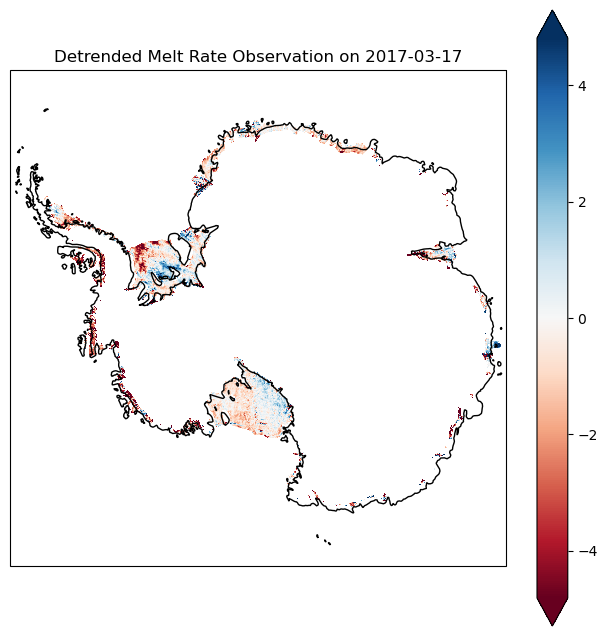

In [9]:
# Plot map of the detrended melt rate for a sample time slice in the right polar stereographic projection

# Select sample time slice
sample_tslice = 100
data_to_plot = obs23_melt_detrend_uniform.isel(time=sample_tslice)

# Set extreme values for the plot colorbar
plot_vmax = np.nanquantile(data_to_plot.values, 0.95)
plot_vmin = np.nanquantile(data_to_plot.values, 0.05)
abs_vmax = max(abs(plot_vmax), abs(plot_vmin))

plt.figure(figsize=(8,8))
ax = plt.axes(projection=crs)
data_to_plot.plot(ax=ax, cmap='RdBu', vmax= abs_vmax, vmin=-abs_vmax)
ax.coastlines()
plt.title('Detrended Melt Rate Observation on {}'.format(data_to_plot.time.values.astype('datetime64[D]')))
plt.show()


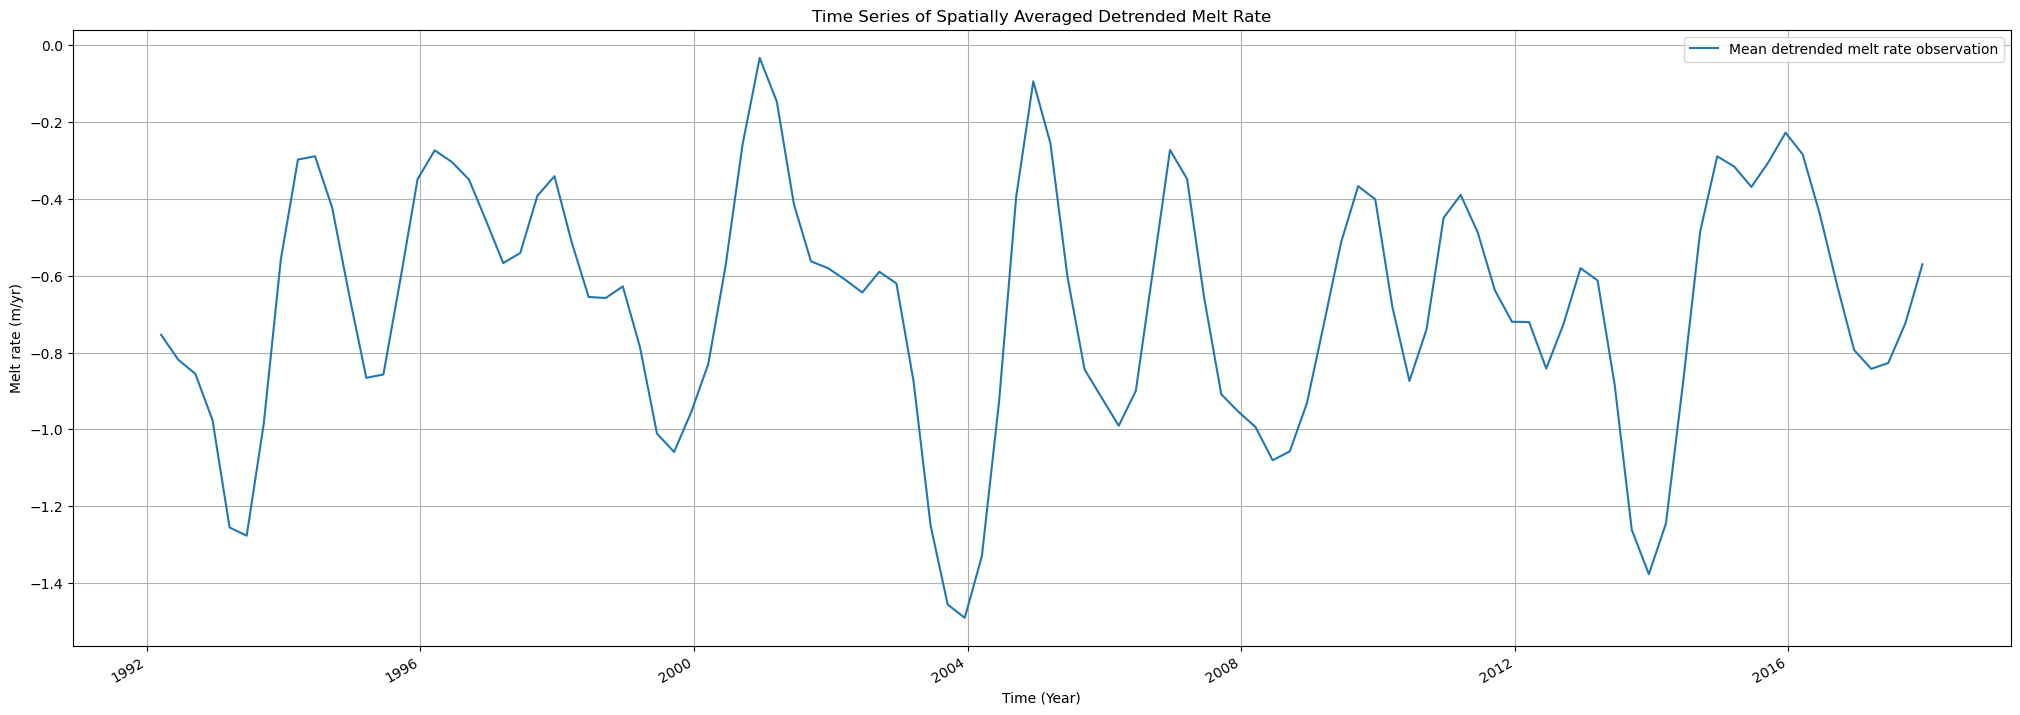

In [28]:
# Plot the time series of the detrended melt rate
plt.figure(figsize=(25,8))
obs23_melt_detrend_uniform_ts.plot(label='Mean detrended melt rate observation')
plt.xlabel('Time (Year)')
plt.ylabel('Melt rate (m/yr)')
plt.title('Time Series of Spatially Averaged Detrended Melt Rate')
plt.legend()
plt.grid()
plt.show()

# Deseasonalize: Remove periodic seasonality/climatology signal

In [29]:
# Deseasonalize (uniform)

obs23_melt_detrend_uniform_deseasonalize_ts = deseasonalize(obs23_melt_detrend_uniform_ts)
climfit = obs23_melt_detrend_uniform_ts - obs23_melt_detrend_uniform_deseasonalize_ts

# Subtract the above climfit from the detrended melt dataset to get the detrended+deseasonalized melt dataset
obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform - climfit
obs23_melt_detrend_uniform_deseasonalize_uniform_ts = obs23_melt_detrend_uniform_deseasonalize_uniform.mean(dim=['x', 'y']).compute()

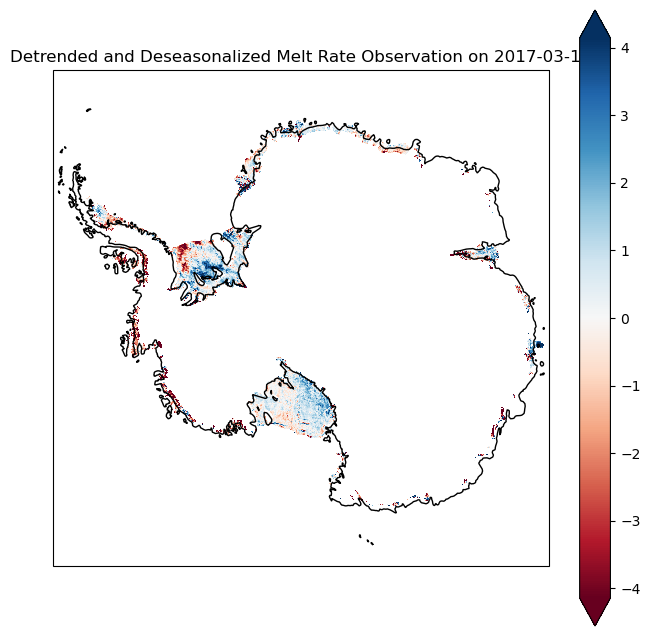

In [31]:
# Plot map of the detrended and deseasonalized melt rate for a sample time slice in the right polar stereographic projection

# Select sample time slice
sample_tslice = 100
data_to_plot = obs23_melt_detrend_uniform_deseasonalize_uniform.isel(time=sample_tslice)

# Set extreme values for the plot colorbar
plot_vmax = np.nanquantile(data_to_plot.values, 0.95)
plot_vmin = np.nanquantile(data_to_plot.values, 0.05)
abs_vmax = max(abs(plot_vmax), abs(plot_vmin))

plt.figure(figsize=(8,8))
ax = plt.axes(projection=crs)
data_to_plot.plot(ax=ax, cmap='RdBu', vmax= abs_vmax, vmin=-abs_vmax)
ax.coastlines()
plt.title('Detrended and Deseasonalized Melt Rate Observation on {}'.format(data_to_plot.time.values.astype('datetime64[D]')))
plt.show()

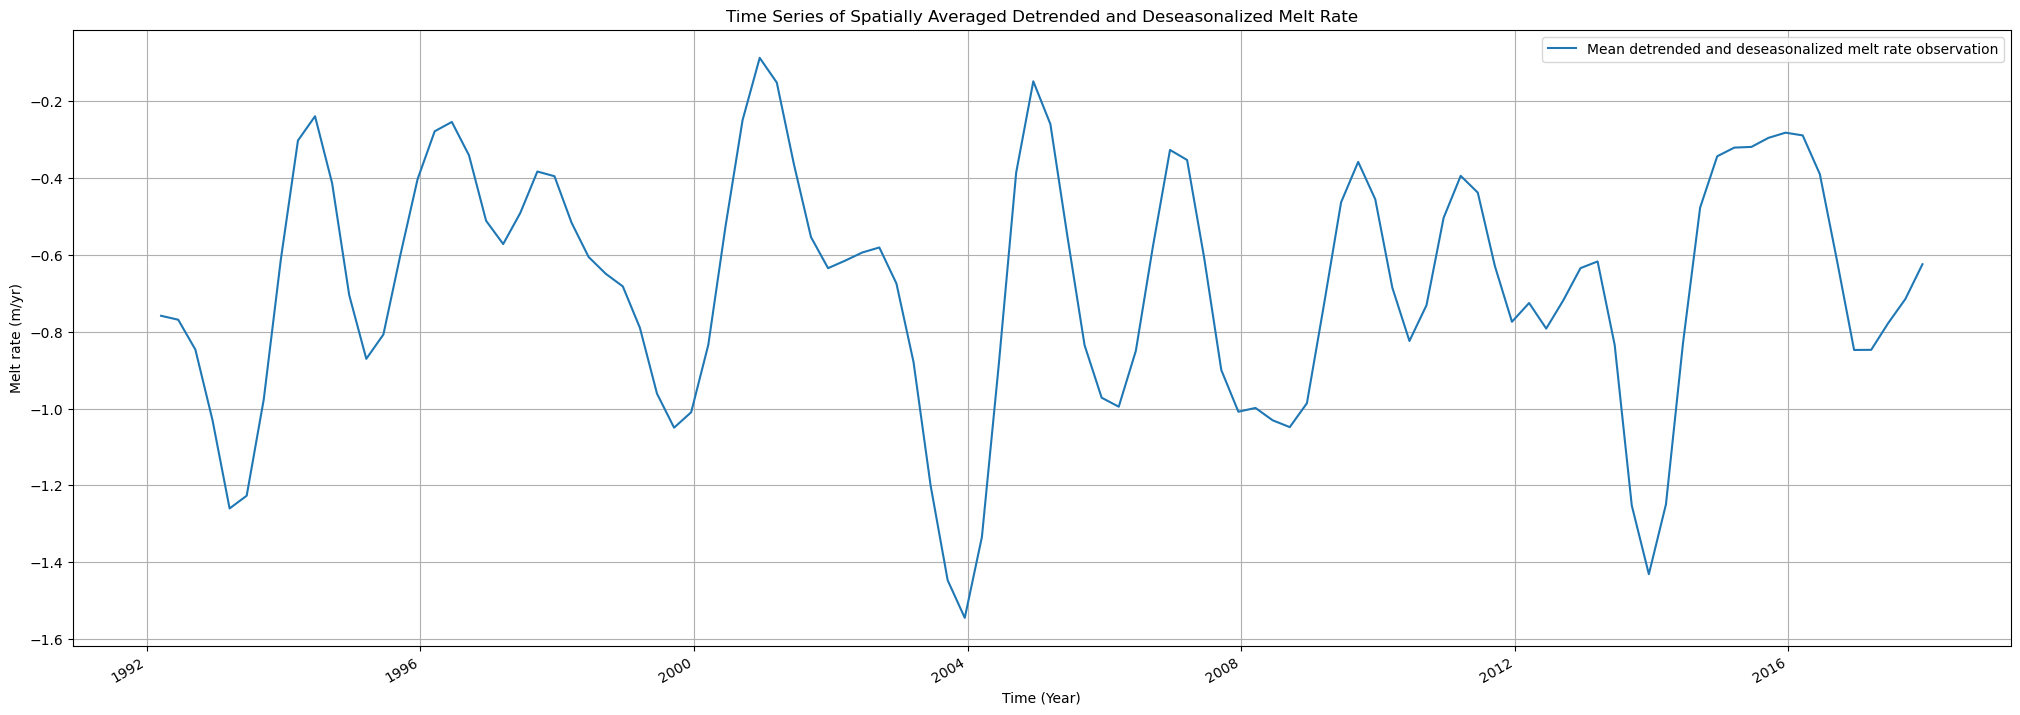

In [30]:
# Plot the time series of the detrended and deseasonalized melt rate
plt.figure(figsize=(25,8))
obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot(label='Mean detrended and deseasonalized melt rate observation')
plt.xlabel('Time (Year)')
plt.ylabel('Melt rate (m/yr)')
plt.title('Time Series of Spatially Averaged Detrended and Deseasonalized Melt Rate')
plt.legend()
plt.grid()
plt.show()

# Pre-processing Summary

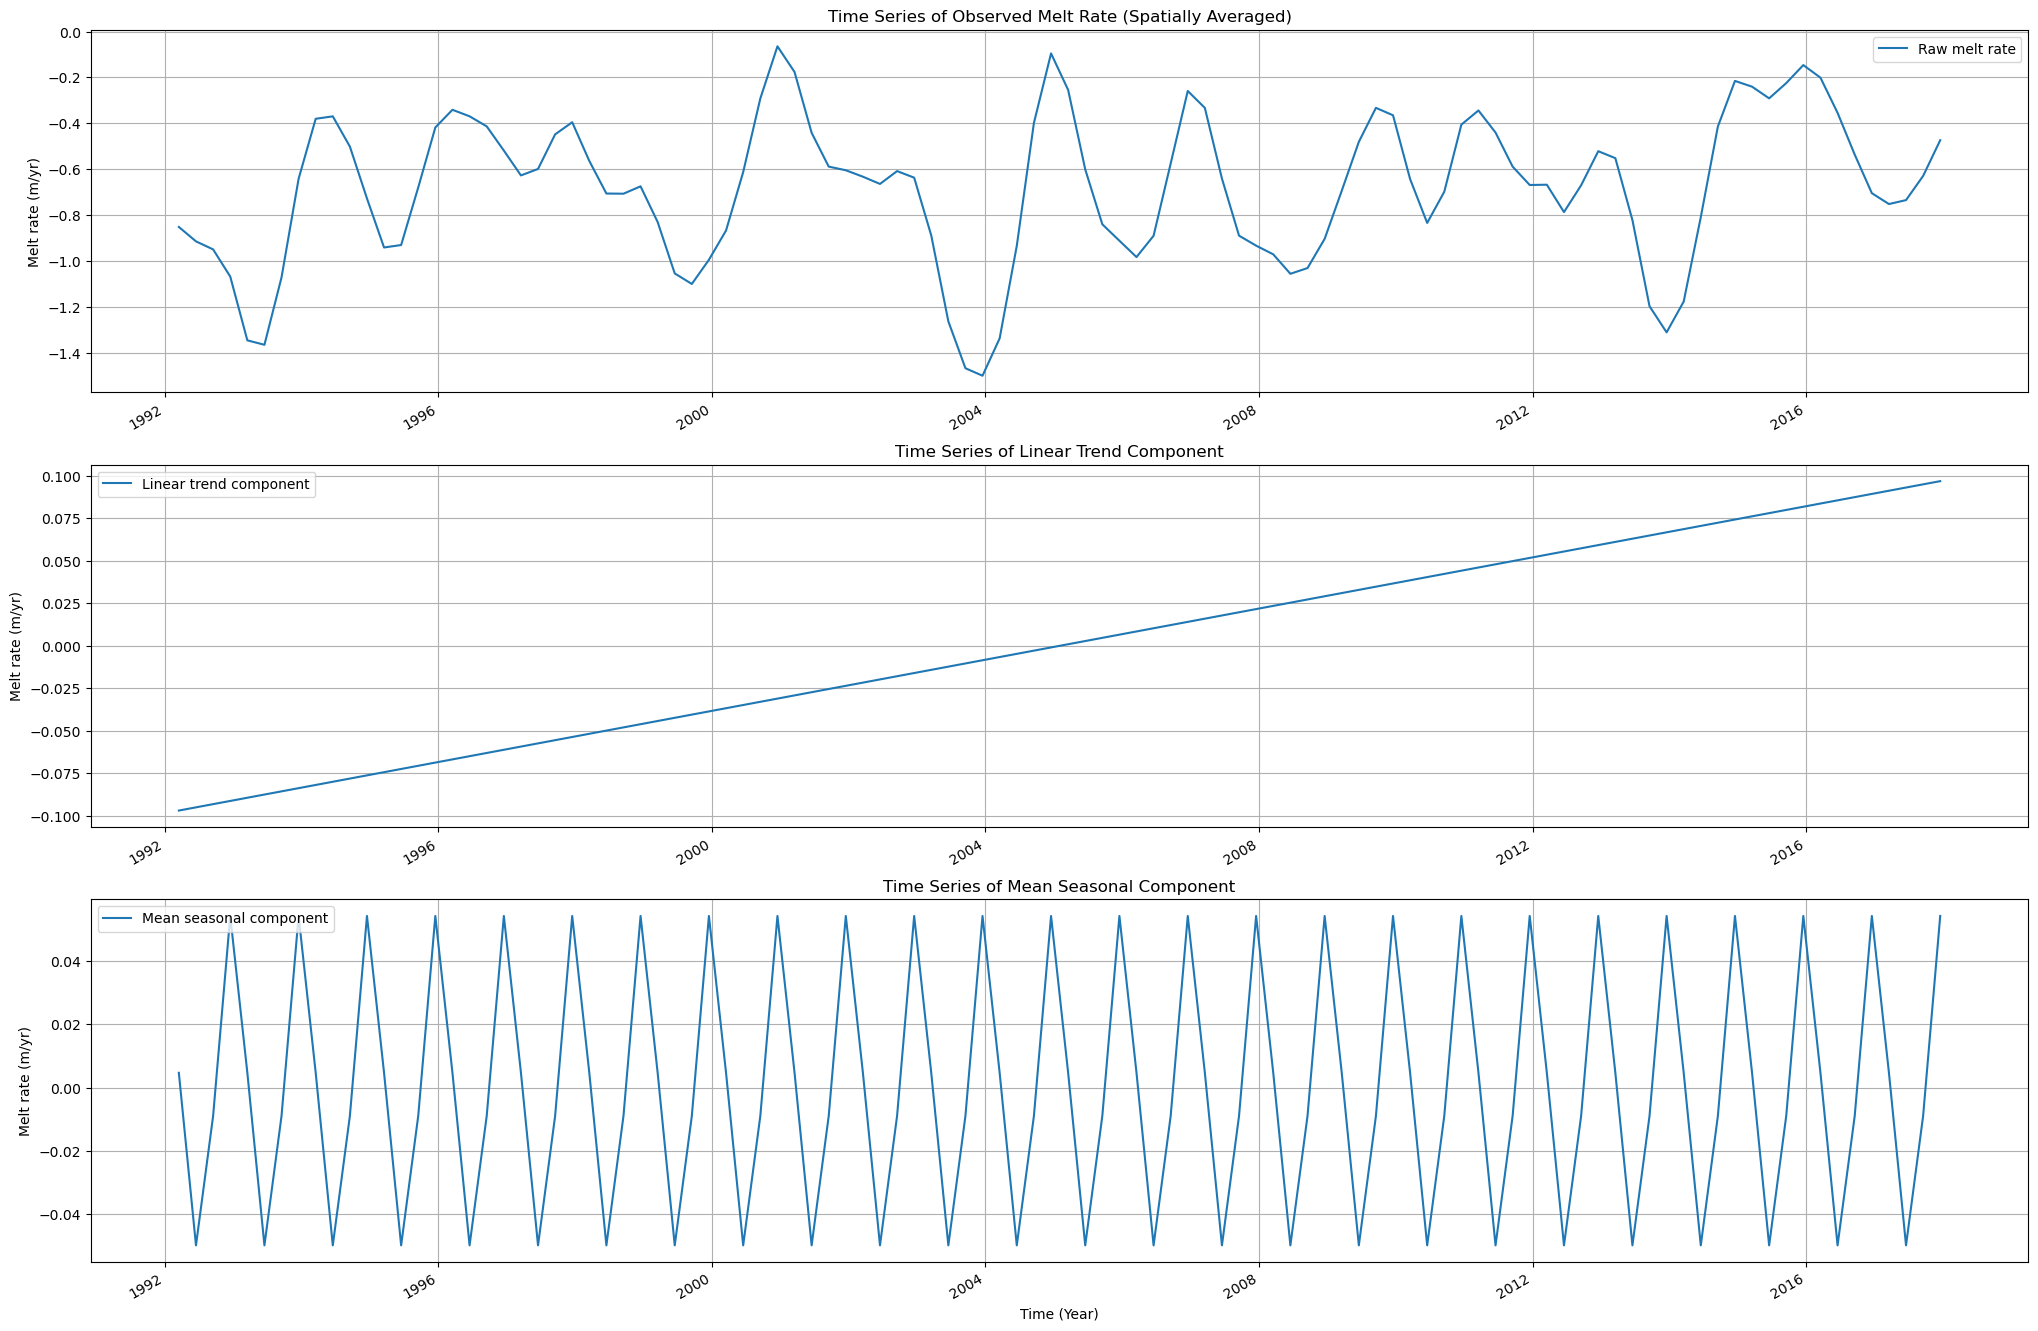

In [31]:
# Plot subplots of the time series for the original mean melt rate, the linear trend component and mean seasonal component

plt.figure(figsize=(25,16))

# Plot the raw melt rate time series, without any xlabel and xticks
plt.subplot(3,1,1)
obs23_melt_ts.plot(label='Raw melt rate')
plt.ylabel('Melt rate (m/yr)')
plt.xlabel('')
# plt.xticks([],[])
plt.title('Time Series of Observed Melt Rate (Spatially Averaged)')
plt.legend()
plt.grid()

# Plot the linear trend component
plt.subplot(3,1,2)
trendfit.plot(label='Linear trend component')
plt.xlabel('')
plt.ylabel('Melt rate (m/yr)')
plt.title('Time Series of Linear Trend Component')
plt.legend()
plt.grid()

# Plot the mean seasonal component
plt.subplot(3,1,3)
climfit.plot(label='Mean seasonal component')
plt.xlabel('Time (Year)')
plt.ylabel('Melt rate (m/yr)')
plt.title('Time Series of Mean Seasonal Component')
plt.legend()
plt.grid()

In [6]:
# Pre-processed detrended and deseasonalized melt datasets

obs23_melt_detrend_uniform_deseasonalize_uniform = xr.open_dataset(main_dir / DIR_processed / "obs23_melt_detrend_uniform_deseasonalize_uniform.nc", chunks={"x":729, "y":729})
obs23_melt_detrend_uniform_deseasonalize_uniform_ts = obs23_melt_detrend_uniform_deseasonalize_uniform.mean(dim=['x', 'y']).compute()

obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform_deseasonalize_uniform.melt
obs23_melt_detrend_uniform_deseasonalize_uniform_ts = obs23_melt_detrend_uniform_deseasonalize_uniform_ts.melt

In [32]:
obs23_draft_tm.rio.write_crs("epsg:3031",inplace=True);
obs23_draft.rio.write_crs("epsg:3031",inplace=True);
obs23_melt_detrend_uniform_deseasonalize_uniform.rio.write_crs("epsg:3031",inplace=True);
#obs23_melt_detrend_uniform.rio.write_crs("epsg:3031",inplace=True);

# Dedraft
Use this section of code only for data exploration and testing. Actual dedraft function for dedrafting and saving of parameter values is provided in the next section.

In [49]:
# Dedraft for individual ice shelves

ice_shelf_name = 'Antarctica'
i = find_ice_shelf_index(ice_shelf_name)

mlt = clip_data(obs23_melt_detrend_uniform_deseasonalize_uniform, i)
h = clip_data(obs23_draft, i)

mlt_tm = mlt.mean(dim='time')
h_tm = h.mean(dim='time')

mlt_coef, mlt_intercept, mlt_pred, mlt_dedraft = dedraft(mlt, h)
mlt_dedraft_ts = mlt_dedraft.mean(dim=['x', 'y']).compute()

ValueError: not enough values to unpack (expected 4, got 2)

In [235]:
obs23_melt_detrend_uniform_deseasonalize_uniform_tm = obs23_melt_detrend_uniform_deseasonalize_uniform.mean(dim='time').compute()
obs23_melt_detrend_uniform_tm = obs23_melt_detrend_uniform.mean(dim='time').compute()
obs23_melt_tm = obs23_melt.mean(dim='time').compute()
obs23_melt_detrend_uniform_tm.plot()
obs_trend_diff = obs23_melt_tm-obs23_melt_detrend_uniform_tm

In [34]:
# Save the mlt_coef and mlt_intercept value at all spatial points in the ice shelf
# Create two dataArrays of shape (x, y) with the mlt_coef and mlt_intercept values

mlt_coef_ds = np.full((mlt_tm.shape[0], mlt_tm.shape[1]), mlt_coef)
mlt_intercept_ds = np.full((mlt_tm.shape[0], mlt_tm.shape[1]), mlt_intercept)

mlt_coef_ds = xr.DataArray(mlt_coef_ds, dims=['y', 'x'], coords={'x': mlt_tm.x, 'y': mlt_tm.y})
mlt_intercept_ds = xr.DataArray(mlt_intercept_ds, dims=['y', 'x'], coords={'x': mlt_tm.x, 'y': mlt_tm.y})

mlt_coef_ds.rio.write_crs("epsg:3031",inplace=True);
mlt_intercept_ds.rio.write_crs("epsg:3031",inplace=True);

# Create a boolean mask for the ice shelf of interest using the icems geometry
# This mask will be used to filter the two data arrays above to define values only inside the ice shelf mask region
ice_shelf_mask = icems.loc[[i],'geometry'].apply(mapping)

# Filter the mlt_coef_ds data array using this mask

mlt_coef_ds = mlt_coef_ds.rio.clip(ice_shelf_mask,icems.crs)
mlt_intercept_ds = mlt_intercept_ds.rio.clip(ice_shelf_mask,icems.crs)

# Rename the mlt_coef_ds and mlt_intercept_ds data arrays to draftDepenBasalMeltAlpha1 and draftDepenBasalMeltAlpha0
mlt_coef_ds.name = 'draftDepenBasalMeltAlpha1'
mlt_coef_ds.attrs['long_name'] = 'Basal melt rate draft dependency coefficient (alpha1 or slope)'
mlt_coef_ds.attrs['units'] = 'm/yr/m'

mlt_intercept_ds.name = 'draftDepenBasalMeltAlpha0'
mlt_intercept_ds.attrs['long_name'] = 'Basal melt rate draft dependency coefficient (alpha0 or intercept)'
mlt_intercept_ds.attrs['units'] = 'm/yr'

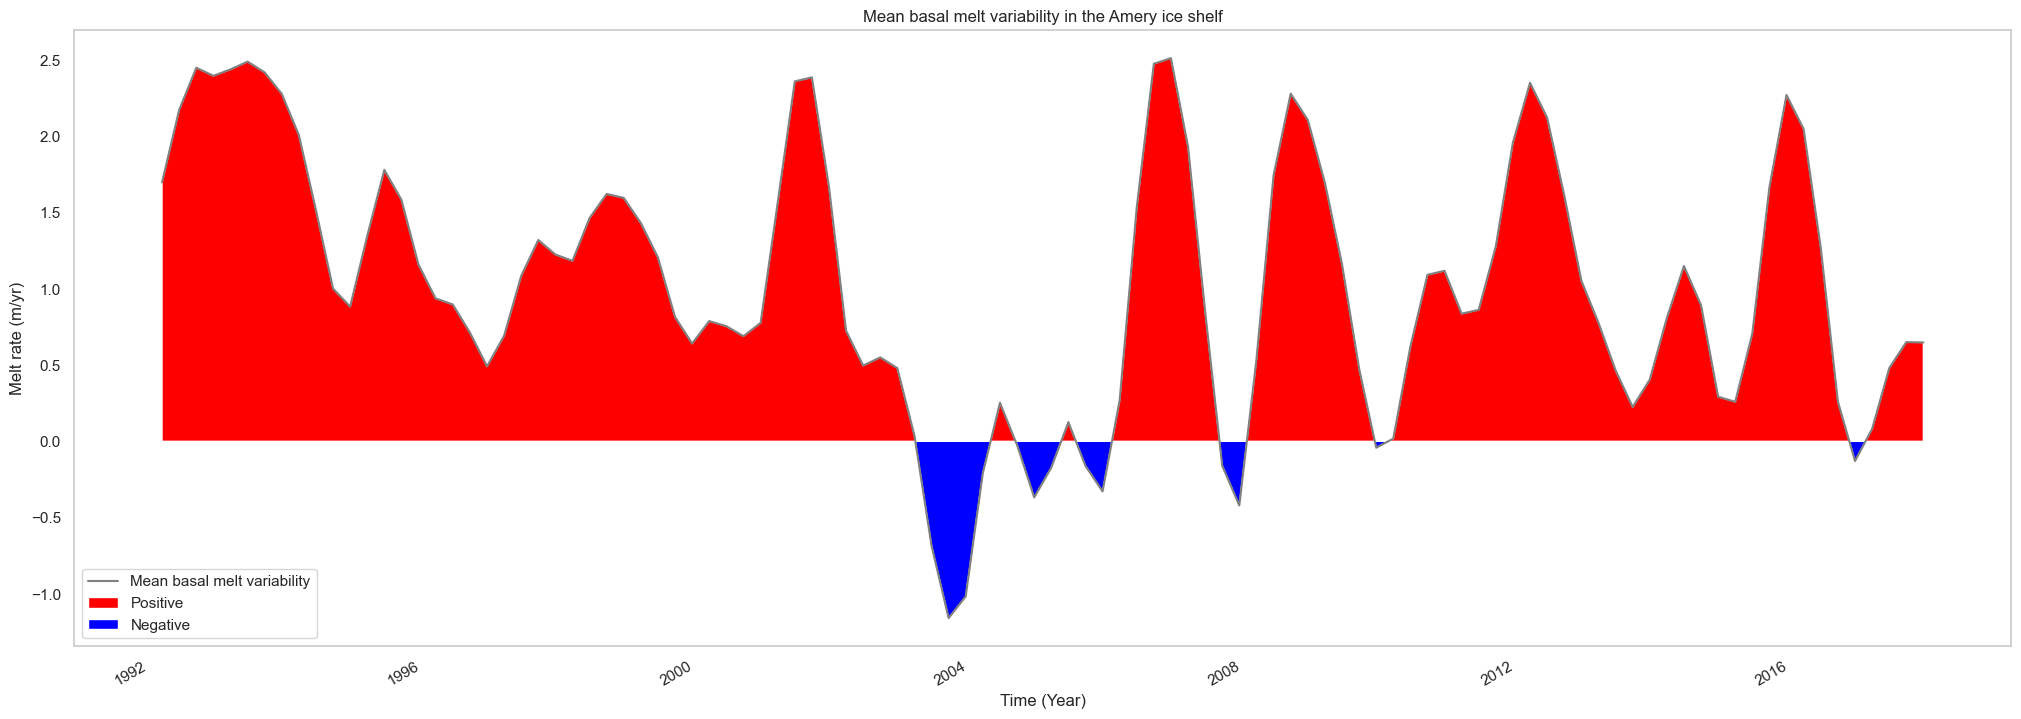

In [48]:
# Plot the time series of the melt rate variability at the deepest point in the ice shelf
plt.figure(figsize=(25,8))
#mlt_full_ts.plot(label='Total melt rate variability')
#obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot(label='Deseasonalized melt rate')
#obs23_melt_ts.plot(label='Raw melt rate')
#climfit.plot(label='Climatology')
mlt_dedraft_ts.plot(color='grey', label='Mean basal melt variability')
# mlt_detrend_ts.plot(label='Detrended melt rate')
# climfit.plot(label='Climatology')
#plt.axhline(0, color='black', lw=1.5)
plt.title('Mean basal melt variability in the {} ice shelf'.format(ice_shelf_name))
#mlt_detrend_uniform_deseasonalize_uniform_ts.plot(label='Deseasonalized melt rate')

# Fill positive values in the melt rate variability with red color and negative values with blue color
# Fill space between the two curves with a light grey color
plt.fill_between(mlt_dedraft_ts.time.values, 0, mlt_dedraft_ts, where=mlt_dedraft_ts >= 0, facecolor='red', interpolate=True, label='Positive')
plt.fill_between(mlt_dedraft_ts.time.values, 0, mlt_dedraft_ts, where=mlt_dedraft_ts <= 0, facecolor='blue', interpolate=True, label='Negative')

plt.xlabel('Time (Year)')
plt.ylabel('Melt rate (m/yr)')
plt.legend()
plt.grid()


# Dedraft for each ice shelf

In [38]:
iceShelfRegions = range(33,133)

def dedraft(data, draft):
    data_tm = data.mean(dim='time')
    draft_tm = draft.mean(dim='time')
    data_stack = data_tm.stack(z=('x', 'y'))
    draft_stack = draft_tm.stack(z=('x', 'y'))
    data_stack_noNaN = data_stack.fillna(0)
    draft_stack_noNaN = draft_stack.fillna(0)
    data_stack_noNaN_vals = data_stack_noNaN.values.reshape(-1,1)
    draft_stack_noNaN_vals = draft_stack_noNaN.values.reshape(-1,1)
    reg = LinearRegression().fit(draft_stack_noNaN_vals, data_stack_noNaN_vals)
    #data_pred_stack_noNaN_vals = reg.predict(draft_stack_noNaN_vals).reshape(-1)
    #data_pred_stack_noNaN = data_stack_noNaN.copy(data=data_pred_stack_noNaN_vals)
    #data_pred_stack = data_pred_stack_noNaN.where(~data_stack.isnull(), np.nan)
    #data_pred = data_pred_stack.unstack('z').transpose()
    #data_dedraft = data - data_pred
    return reg.coef_, reg.intercept_#, data_pred, data_dedraft


for i in iceShelfRegions:
    print('extracting data for catchment {}'.format(icems.name.values[i]))
    mlt = clip_data(obs23_melt_detrend_uniform_deseasonalize_uniform, i)
    h = clip_data(obs23_draft, i)
    mlt_tm = mlt.mean(dim='time')
    h_tm = h.mean(dim='time')
    print('calculating linear regression for catchment {}'.format(icems.name.values[i]))
    mlt_coef, mlt_intercept = dedraft(mlt, h)

    mlt_coef_ds = np.full((mlt_tm.shape[0], mlt_tm.shape[1]), mlt_coef)
    mlt_intercept_ds = np.full((mlt_tm.shape[0], mlt_tm.shape[1]), mlt_intercept)
    mlt_coef_ds = xr.DataArray(mlt_coef_ds, dims=['y', 'x'], coords={'x': mlt_tm.x, 'y': mlt_tm.y})
    mlt_intercept_ds = xr.DataArray(mlt_intercept_ds, dims=['y', 'x'], coords={'x': mlt_tm.x, 'y': mlt_tm.y})
    mlt_coef_ds.rio.write_crs("epsg:3031",inplace=True);
    mlt_intercept_ds.rio.write_crs("epsg:3031",inplace=True);
    # Create a boolean mask for the ice shelf of interest using the icems geometry
    # # This mask will be used to filter the two data arrays above to define values only inside the ice shelf mask region
    ice_shelf_mask = icems.loc[[i],'geometry'].apply(mapping)
    # Filter the mlt_coef_ds data array using this mask
    mlt_coef_ds = mlt_coef_ds.rio.clip(ice_shelf_mask,icems.crs)
    mlt_intercept_ds = mlt_intercept_ds.rio.clip(ice_shelf_mask,icems.crs)
    
    mlt_coef_ds.name = 'draftDepenBasalMeltAlpha1'
    mlt_coef_ds.attrs['long_name'] = 'Basal melt rate draft dependency coefficient (alpha1 or slope)'
    mlt_coef_ds.attrs['units'] = 'm/yr/m'

    mlt_intercept_ds.name = 'draftDepenBasalMeltAlpha0'
    mlt_intercept_ds.attrs['long_name'] = 'Basal melt rate draft dependency coefficient (alpha0 or intercept)'
    mlt_intercept_ds.attrs['units'] = 'm/yr'
    
    # Save mlt_coef_ds and mlt_intercept_ds data arrays to a single xarray dataset
    mlt_coefs = xr.Dataset({'draftDepenBasalMeltAlpha1': mlt_coef_ds, 'draftDepenBasalMeltAlpha0': mlt_intercept_ds})

    mlt_coefs.to_netcdf(main_dir / DIR_processed / 'draft_dependence_params_241014/draftDepenBasalMeltAlpha_{}.nc'.format(icems.name.values[i]))
    print('{} file saved'.format(icems.name.values[i]))
    del mlt, h, mlt_tm, h_tm, mlt_coef, mlt_intercept, mlt_coef_ds, mlt_intercept_ds, ice_shelf_mask, mlt_coefs
    print('deleted interim variables')
    gc.collect()

extracting data for catchment Abbot
calculating linear regression for catchment Abbot
Abbot file saved
deleted interim variables
extracting data for catchment Amery
calculating linear regression for catchment Amery
Amery file saved
deleted interim variables
extracting data for catchment Atka
calculating linear regression for catchment Atka
Atka file saved
deleted interim variables
extracting data for catchment Aviator
calculating linear regression for catchment Aviator
Aviator file saved
deleted interim variables
extracting data for catchment Bach
calculating linear regression for catchment Bach
Bach file saved
deleted interim variables
extracting data for catchment Baudouin
calculating linear regression for catchment Baudouin
Baudouin file saved
deleted interim variables
extracting data for catchment Borchgrevink
calculating linear regression for catchment Borchgrevink
Borchgrevink file saved
deleted interim variables
extracting data for catchment Brahms
calculating linear regression 

2024-10-14 14:26:00,009 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


Gillet file saved
deleted interim variables
extracting data for catchment Hamilton
calculating linear regression for catchment Hamilton


2024-10-14 14:26:04,136 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


Hamilton file saved
deleted interim variables
extracting data for catchment Hannan
calculating linear regression for catchment Hannan


2024-10-14 14:26:07,335 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


Hannan file saved
deleted interim variables
extracting data for catchment HarbordGlacier
calculating linear regression for catchment HarbordGlacier


2024-10-14 14:26:10,725 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


HarbordGlacier file saved
deleted interim variables
extracting data for catchment Helen
calculating linear regression for catchment Helen


2024-10-14 14:26:14,003 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


Helen file saved
deleted interim variables
extracting data for catchment Holmes
calculating linear regression for catchment Holmes


2024-10-14 14:26:18,444 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


Holmes file saved
deleted interim variables
extracting data for catchment HolmesWest
calculating linear regression for catchment HolmesWest


2024-10-14 14:26:21,104 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


HolmesWest file saved
deleted interim variables
extracting data for catchment Hull
calculating linear regression for catchment Hull


2024-10-14 14:26:24,238 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


Hull file saved
deleted interim variables
extracting data for catchment Jelbart
calculating linear regression for catchment Jelbart


2024-10-14 14:26:27,450 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


Jelbart file saved
deleted interim variables
extracting data for catchment Land
calculating linear regression for catchment Land


2024-10-14 14:26:30,772 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Land file saved
deleted interim variables
extracting data for catchment Larsen_B
calculating linear regression for catchment Larsen_B


2024-10-14 14:26:34,826 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Larsen_B file saved
deleted interim variables
extracting data for catchment Larsen_C
calculating linear regression for catchment Larsen_C


2024-10-14 14:26:38,841 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


Larsen_C file saved
deleted interim variables
extracting data for catchment Larsen_D
calculating linear regression for catchment Larsen_D


2024-10-14 14:26:42,791 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


Larsen_D file saved
deleted interim variables
extracting data for catchment Larsen_E
calculating linear regression for catchment Larsen_E


2024-10-14 14:26:46,490 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


Larsen_E file saved
deleted interim variables
extracting data for catchment Larsen_F
calculating linear regression for catchment Larsen_F


2024-10-14 14:26:50,879 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Larsen_F file saved
deleted interim variables
extracting data for catchment Larsen_G
calculating linear regression for catchment Larsen_G


2024-10-14 14:26:53,915 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Larsen_G file saved
deleted interim variables
extracting data for catchment Lazarev
calculating linear regression for catchment Lazarev


2024-10-14 14:26:57,524 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Lazarev file saved
deleted interim variables
extracting data for catchment Lillie
calculating linear regression for catchment Lillie


2024-10-14 14:27:00,666 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Lillie file saved
deleted interim variables
extracting data for catchment Mariner
calculating linear regression for catchment Mariner


2024-10-14 14:27:04,010 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Mariner file saved
deleted interim variables
extracting data for catchment Matusevitch
calculating linear regression for catchment Matusevitch


2024-10-14 14:27:06,890 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Matusevitch file saved
deleted interim variables
extracting data for catchment Mendelssohn
calculating linear regression for catchment Mendelssohn


2024-10-14 14:27:10,091 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Mendelssohn file saved
deleted interim variables
extracting data for catchment Mertz
calculating linear regression for catchment Mertz


2024-10-14 14:27:17,882 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Mertz file saved
deleted interim variables
extracting data for catchment Moscow_University
calculating linear regression for catchment Moscow_University


2024-10-14 14:27:24,684 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Moscow_University file saved
deleted interim variables
extracting data for catchment Moubray
calculating linear regression for catchment Moubray


2024-10-14 14:27:28,070 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Moubray file saved
deleted interim variables
extracting data for catchment Mulebreen
calculating linear regression for catchment Mulebreen


2024-10-14 14:27:31,187 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Mulebreen file saved
deleted interim variables
extracting data for catchment Myers
calculating linear regression for catchment Myers


2024-10-14 14:27:34,254 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Myers file saved
deleted interim variables
extracting data for catchment Nansen
calculating linear regression for catchment Nansen


2024-10-14 14:27:37,200 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Nansen file saved
deleted interim variables
extracting data for catchment Nickerson
calculating linear regression for catchment Nickerson


2024-10-14 14:27:40,603 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)


Nickerson file saved
deleted interim variables
extracting data for catchment Ninnis
calculating linear regression for catchment Ninnis


2024-10-14 14:27:44,231 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Ninnis file saved
deleted interim variables
extracting data for catchment Nivl
calculating linear regression for catchment Nivl


2024-10-14 14:27:47,399 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Nivl file saved
deleted interim variables
extracting data for catchment Noll
calculating linear regression for catchment Noll


2024-10-14 14:27:50,419 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Noll file saved
deleted interim variables
extracting data for catchment Nordenskjold
calculating linear regression for catchment Nordenskjold


2024-10-14 14:27:54,645 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Nordenskjold file saved
deleted interim variables
extracting data for catchment Pine_Island
calculating linear regression for catchment Pine_Island


2024-10-14 14:28:01,080 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Pine_Island file saved
deleted interim variables
extracting data for catchment PourquoiPas
calculating linear regression for catchment PourquoiPas


2024-10-14 14:28:04,197 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


PourquoiPas file saved
deleted interim variables
extracting data for catchment Prince_Harald
calculating linear regression for catchment Prince_Harald


2024-10-14 14:28:08,398 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Prince_Harald file saved
deleted interim variables
extracting data for catchment Publications
calculating linear regression for catchment Publications


2024-10-14 14:28:12,816 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Publications file saved
deleted interim variables
extracting data for catchment Quar
calculating linear regression for catchment Quar


2024-10-14 14:28:15,918 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Quar file saved
deleted interim variables
extracting data for catchment Rayner_Thyer
calculating linear regression for catchment Rayner_Thyer


2024-10-14 14:28:19,457 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Rayner_Thyer file saved
deleted interim variables
extracting data for catchment Rennick
calculating linear regression for catchment Rennick


2024-10-14 14:28:22,668 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Rennick file saved
deleted interim variables
extracting data for catchment Richter
calculating linear regression for catchment Richter


2024-10-14 14:28:25,921 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Richter file saved
deleted interim variables
extracting data for catchment Riiser-Larsen
calculating linear regression for catchment Riiser-Larsen


2024-10-14 14:28:29,190 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Riiser-Larsen file saved
deleted interim variables
extracting data for catchment Ronne
calculating linear regression for catchment Ronne


2024-10-14 14:28:35,758 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


Ronne file saved
deleted interim variables
extracting data for catchment Western_Ross
calculating linear regression for catchment Western_Ross


2024-10-14 14:28:49,127 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


Western_Ross file saved
deleted interim variables
extracting data for catchment Eastern_Ross
calculating linear regression for catchment Eastern_Ross


2024-10-14 14:28:56,444 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


Eastern_Ross file saved
deleted interim variables
extracting data for catchment Shackleton
calculating linear regression for catchment Shackleton


2024-10-14 14:28:59,712 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Shackleton file saved
deleted interim variables
extracting data for catchment Shirase
calculating linear regression for catchment Shirase


2024-10-14 14:29:06,174 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


Shirase file saved
deleted interim variables
extracting data for catchment Slava
calculating linear regression for catchment Slava


2024-10-14 14:29:09,179 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Slava file saved
deleted interim variables
extracting data for catchment SmithInlet
calculating linear regression for catchment SmithInlet


2024-10-14 14:29:11,906 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


SmithInlet file saved
deleted interim variables
extracting data for catchment Stange
calculating linear regression for catchment Stange


2024-10-14 14:29:15,184 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Stange file saved
deleted interim variables
extracting data for catchment Sulzberger
calculating linear regression for catchment Sulzberger


2024-10-14 14:29:18,506 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Sulzberger file saved
deleted interim variables
extracting data for catchment Suvorov
calculating linear regression for catchment Suvorov


2024-10-14 14:29:21,642 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Suvorov file saved
deleted interim variables
extracting data for catchment Swinburne
calculating linear regression for catchment Swinburne


2024-10-14 14:29:24,837 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Swinburne file saved
deleted interim variables
extracting data for catchment Thwaites
calculating linear regression for catchment Thwaites


2024-10-14 14:29:28,330 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


Thwaites file saved
deleted interim variables
extracting data for catchment Tinker
calculating linear regression for catchment Tinker


2024-10-14 14:29:30,680 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Tinker file saved
deleted interim variables
extracting data for catchment Totten
calculating linear regression for catchment Totten


2024-10-14 14:29:34,297 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Totten file saved
deleted interim variables
extracting data for catchment Tracy_Tremenchus
calculating linear regression for catchment Tracy_Tremenchus


2024-10-14 14:29:37,030 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Tracy_Tremenchus file saved
deleted interim variables
extracting data for catchment Tucker
calculating linear regression for catchment Tucker


2024-10-14 14:29:40,686 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Tucker file saved
deleted interim variables
extracting data for catchment Underwood
calculating linear regression for catchment Underwood


2024-10-14 14:29:43,472 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Underwood file saved
deleted interim variables
extracting data for catchment Utsikkar
calculating linear regression for catchment Utsikkar


2024-10-14 14:29:46,786 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Utsikkar file saved
deleted interim variables
extracting data for catchment Venable
calculating linear regression for catchment Venable


2024-10-14 14:29:49,896 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Venable file saved
deleted interim variables
extracting data for catchment Verdi
calculating linear regression for catchment Verdi


2024-10-14 14:29:52,725 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Verdi file saved
deleted interim variables
extracting data for catchment Vigrid
calculating linear regression for catchment Vigrid


2024-10-14 14:29:55,995 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Vigrid file saved
deleted interim variables
extracting data for catchment Vincennes
calculating linear regression for catchment Vincennes


2024-10-14 14:29:59,691 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Vincennes file saved
deleted interim variables
extracting data for catchment Voyeykov
calculating linear regression for catchment Voyeykov


2024-10-14 14:30:04,183 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Voyeykov file saved
deleted interim variables
extracting data for catchment West
calculating linear regression for catchment West


2024-10-14 14:30:08,458 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


West file saved
deleted interim variables
extracting data for catchment Wilkins
calculating linear regression for catchment Wilkins


2024-10-14 14:30:12,523 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


Wilkins file saved
deleted interim variables
extracting data for catchment Wilma_Robert_Downer
calculating linear regression for catchment Wilma_Robert_Downer


2024-10-14 14:30:16,964 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


Wilma_Robert_Downer file saved
deleted interim variables
extracting data for catchment Withrow
calculating linear regression for catchment Withrow


2024-10-14 14:30:22,590 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


Withrow file saved
deleted interim variables
extracting data for catchment Wordie
calculating linear regression for catchment Wordie


2024-10-14 14:30:26,137 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


Wordie file saved
deleted interim variables
extracting data for catchment Wylde
calculating linear regression for catchment Wylde


2024-10-14 14:30:29,301 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


Wylde file saved
deleted interim variables
extracting data for catchment Zubchatyy
calculating linear regression for catchment Zubchatyy


2024-10-14 14:30:32,427 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


Zubchatyy file saved
deleted interim variables


# Merge ice shelf draft parameter values

In [46]:
# Merge draft dependence parameters for all ice shelves into a single xarray dataset

iceShelfRegions = range(33,133)
ds = xr.Dataset()
for i in iceShelfRegions:
    ds = xr.merge([ds, xr.open_dataset(main_dir / DIR_processed / 'draft_dependence_params_241014/draftDepenBasalMeltAlpha_{}.nc'.format(icems.name.values[i]))])

ds.to_netcdf(main_dir / DIR_processed / 'draft_dependence_params_241014/draftDepenBasalMeltAlpha.nc')

In [7]:
# Load the draft dependence parameters for all ice shelves
draftDepenBasalMeltAlphaParams = xr.open_dataset(main_dir / DIR_processed / 'draft_dependence_params_241014/draftDepenBasalMeltAlpha.nc')

In [9]:
# Fill NaN values in the draft dependence parameters with 0 within the ice sheet region, i.e., ice shelf masks
draftDepenBasalMeltAlphaParams_noNaN = draftDepenBasalMeltAlphaParams.fillna(0)

In [12]:
draftDepenBasalMeltAlphaParams_noNaN.to_netcdf(main_dir / DIR_processed / 'draft_dependence_params_241014/draftDepenBasalMeltAlpha_noNaN.nc')

2024-10-19 11:54:55,026 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 0 memory: 19 MB fds: 35>>
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed/system_monitor.py", line 134, in update
    net_ioc = psutil.net_io_counters()
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/psutil/__init__.py", line 2114, in net_io_counters
    rawdict = _psplatform.net_io_counters()
OSError: [Errno 12] Cannot allocate memory


# Plot draft parameters 

This section plots maps of extrapolated draft parameter values for all ice shelves (from the above merge step) using a custom defined random colormap

## Define random colormap

Number of labels: 100


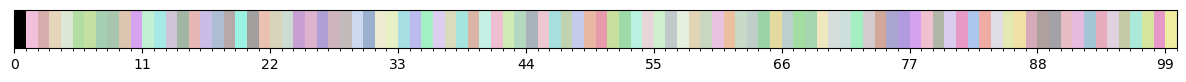

In [43]:
# Generate random colormap
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np

    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

new_cmap = rand_cmap(100, type='soft', first_color_black=True, last_color_black=False, verbose=True)


# Plot the draft dependence co-efficients

Text(0.5, 1.0, 'Basal melt rate draft dependency coefficient (alpha1) for ice shelves')

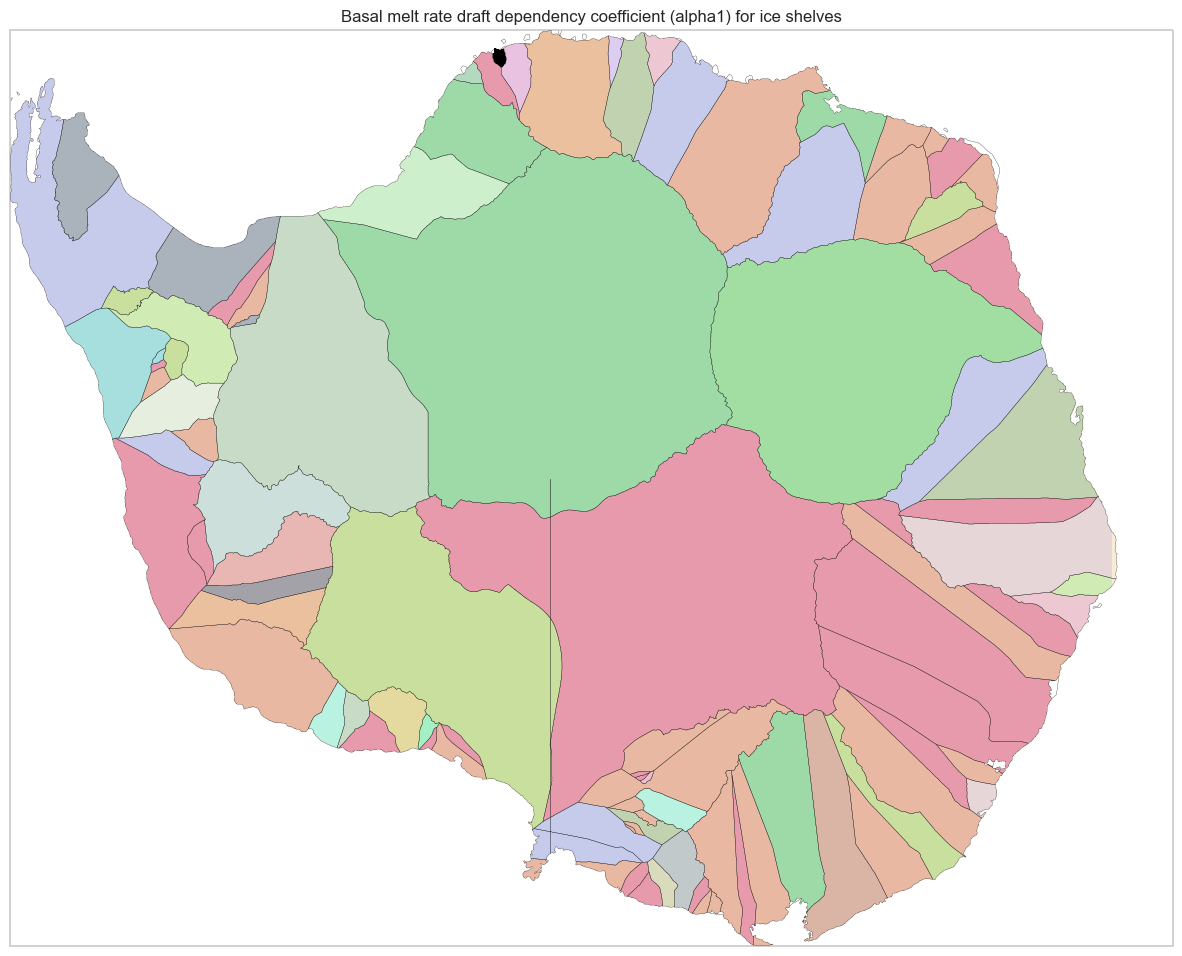

In [50]:
# Note the colorbar extent is set to half of the max of the 1% and 99% quantiles in the raw data variable for better visualization.
obs23_melt_tm_vmin = np.nanquantile(obs23_melt_tm.values, 0.01)
obs23_melt_tm_vmax = np.nanquantile(obs23_melt_tm.values, 0.99)

# Plot figure

sns.set_theme(style="whitegrid")

plt.figure(figsize=(15,15))
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

icems[33:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
icems[33:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=7)


#ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
ax1.coastlines(lw=0.2)

ds.draftDepenBasalMeltAlpha0.plot(ax=ax1, zorder=4, cmap=new_cmap, add_colorbar=False)
# obs23_melt_tm.plot(ax=ax1, vmin=-abs(obs23_melt_tm_vmin)/4, vmax=abs(obs23_melt_tm_vmin)/4, cmap='RdBu_r', cbar_kwargs={'label': 'Basal melt rate (m/yr)'}, zorder=5)
# plt.title('Mean ice shelf basal melt rate from satellite observations (1992-2017)')

plt.title('Basal melt rate draft dependency coefficient (alpha1) for ice shelves')

Text(0.5, 1.0, 'Basal melt rate draft dependency coefficient (alpha1) for ice shelves')

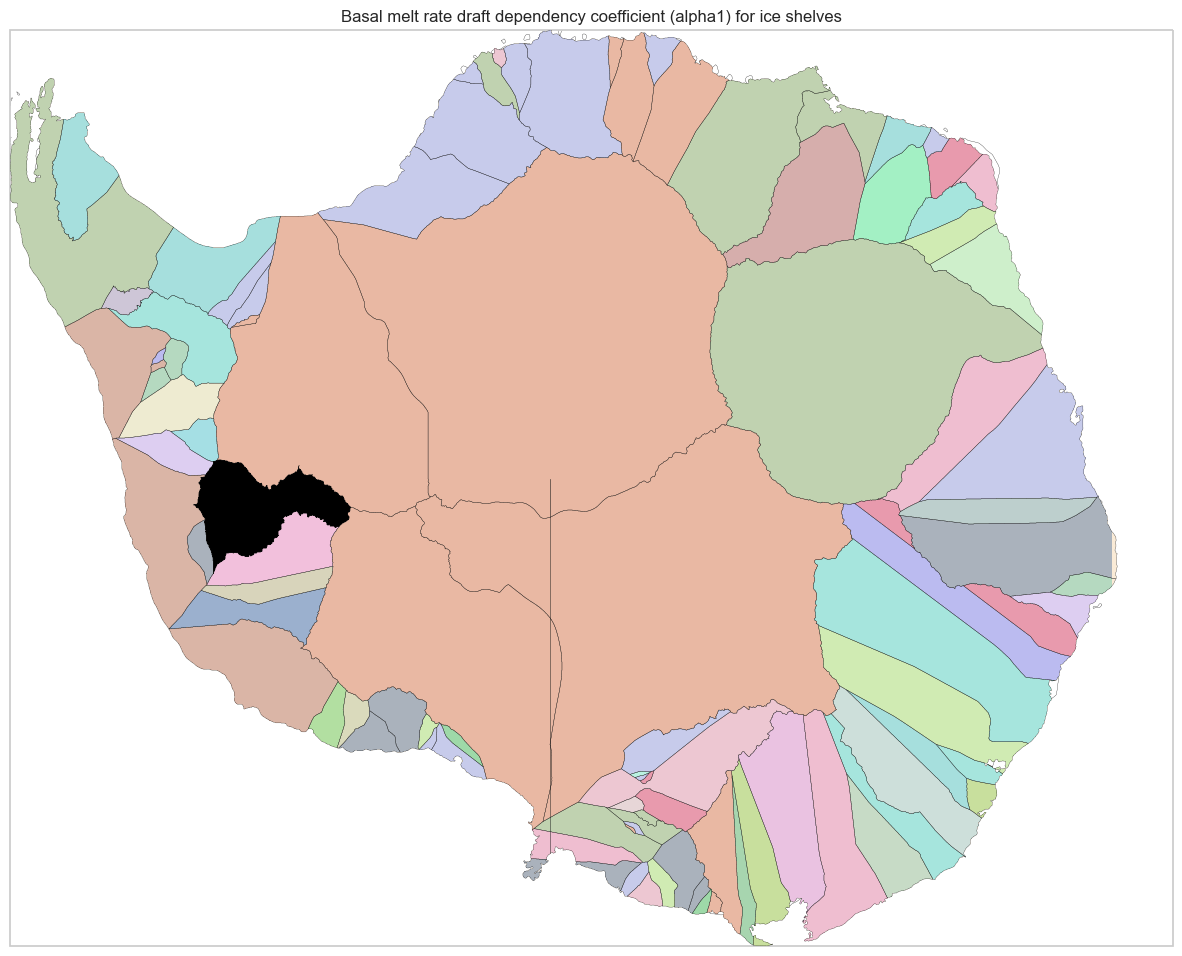

In [51]:
# Note the colorbar extent is set to half of the max of the 1% and 99% quantiles in the raw data variable for better visualization.
obs23_melt_tm_vmin = np.nanquantile(obs23_melt_tm.values, 0.01)
obs23_melt_tm_vmax = np.nanquantile(obs23_melt_tm.values, 0.99)

# Plot figure

sns.set_theme(style="whitegrid")

plt.figure(figsize=(15,15))
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

icems[33:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
icems[33:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=7)


#ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
ax1.coastlines(lw=0.2)

ds.draftDepenBasalMeltAlpha1.plot(ax=ax1, zorder=4, cmap=new_cmap, add_colorbar=False)
# obs23_melt_tm.plot(ax=ax1, vmin=-abs(obs23_melt_tm_vmin)/4, vmax=abs(obs23_melt_tm_vmin)/4, cmap='RdBu_r', cbar_kwargs={'label': 'Basal melt rate (m/yr)'}, zorder=5)
# plt.title('Mean ice shelf basal melt rate from satellite observations (1992-2017)')

plt.title('Basal melt rate draft dependency coefficient (alpha1) for ice shelves')

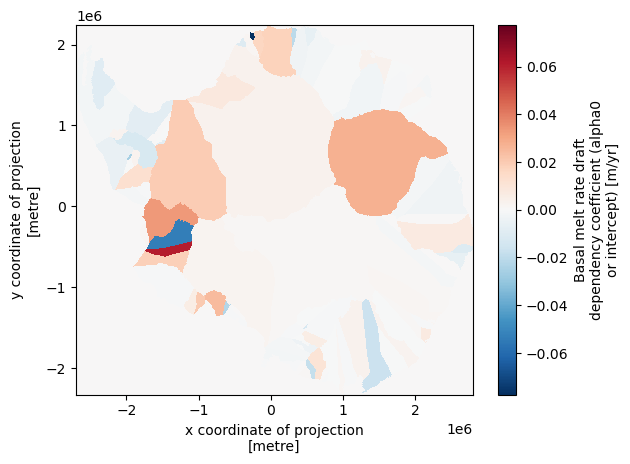

In [11]:
draftDepenBasalMeltAlphaParams_noNaN.draftDepenBasalMeltAlpha0.plot()

In [ ]:
s = '/Users/smurugan9/research/aislens/AISLENS/data/processed/draft_dependence_params/draftDepenBasalMeltAlpha.nc'
d = '/Users/smurugan9/research/DATA/MALI_projects/ISMIP6_2300/AIS_8to30km_IC_draftDepenLinRegress.nc'



In [ ]:
# TODO:
# Copy /Users/smurugan9/research/DATA/MALI_projects/ISMIP6_2300/AIS_8to30km_IC_draftDepenLinRegress.nc to PACE
# Setup compass experiment for draft dependence configuration
# Create floatingBasalMassBalAdjustment.nc (linear trend, seasonality, SORRM variability) for the draft dependence configuration
# run MALI experiment

